In [1]:
import numpy as np
import pandas as pd
import itertools
import random
import pulp
# import gurobipy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
df = pd.read_csv('test.csv')

In [4]:
df

,JOURNEY_ID,LISTING,ORDER_INDEX,VOLUME,WEIGHT,LAT,LNG,ACTION,CUSTOMER_TIMESLOT_START,CUSTOMER_TIMESLOT_END
0,194333,7985885,1,2994750,180,51.534870,-2.586000,pickup,2023-09-15T10:00:00Z,2023-09-15T16:00:00Z
1,194333,7985885,6,-2994750,-180,51.498838,-2.540213,delivery,2023-09-14T23:00:00Z,2023-09-15T22:59:59Z
2,194333,8040758,2,6101360,367,51.438089,-2.748221,pickup,2023-09-15T09:00:00Z,2023-09-15T14:00:00Z
3,194333,8040758,7,-6101360,-367,51.435782,-2.761534,delivery,2023-09-14T23:00:00Z,2023-09-15T22:59:59Z
4,194333,8043966,3,1526040,51,51.327580,-2.872980,pickup,2023-09-15T14:00:00Z,2023-09-15T15:00:00Z
5,194333,8043966,8,-1526040,-51,51.436162,-2.761252,delivery,2023-09-14T23:00:00Z,2023-09-15T22:59:59Z
6,194333,8049581,4,7350334,348,51.497130,-2.572550,pickup,2023-09-15T07:00:00Z,2023-09-15T08:00:00Z
7,194333,8049581,9,-7350334,-348,51.503330,-2.648020,delivery,2023-09-14T23:00:00Z,2023-09-15T22:59:59Z
8,194333,8049945,5,1242000,90,51.469130,-2.606940,pickup,2023-09-15T07:00:00Z,2023-09-15T10:00:00Z
9,194333,8049945,10,-1242000,-90,51.368190,-2.912540,delivery,2023-09-14T23:00:00Z,2023-09-15T22:59:59Z


In [23]:
df.dtypes

JOURNEY_ID                   int64
LISTING                      int64
ORDER_INDEX                  int64
VOLUME                       int64
WEIGHT                       int64
LAT                        float64
LNG                        float64
ACTION                      object
CUSTOMER_TIMESLOT_START     object
CUSTOMER_TIMESLOT_END       object
dtype: object

In [3]:
df['CUSTOMER_TIMESLOT_START'] = pd.to_datetime(df['CUSTOMER_TIMESLOT_START'])
df['CUSTOMER_TIMESLOT_END'] = pd.to_datetime(df['CUSTOMER_TIMESLOT_END'])

df['mins_start'] = df['CUSTOMER_TIMESLOT_START'].dt.hour * 60 + df['CUSTOMER_TIMESLOT_START'].dt.minute
df['mins_end'] = df['CUSTOMER_TIMESLOT_END'].dt.hour * 60 + df['CUSTOMER_TIMESLOT_END'].dt.minute

In [4]:
# depends on the data date
today = pd.to_datetime('2023-09-15')

# if the start data is the previous date then repplace with 0
df.loc[df['CUSTOMER_TIMESLOT_START'].dt.date < today, 'mins_start'] = 0

/usr/local/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [5]:
df

,JOURNEY_ID,LISTING,ORDER_INDEX,VOLUME,WEIGHT,LAT,LNG,ACTION,CUSTOMER_TIMESLOT_START,CUSTOMER_TIMESLOT_END,mins_start,mins_end
0,194333,7985885,1,2994750,180,51.534870,-2.586000,pickup,2023-09-15 10:00:00+00:00,2023-09-15 16:00:00+00:00,600,960
1,194333,7985885,6,-2994750,-180,51.498838,-2.540213,delivery,2023-09-14 23:00:00+00:00,2023-09-15 22:59:59+00:00,0,1379
2,194333,8040758,2,6101360,367,51.438089,-2.748221,pickup,2023-09-15 09:00:00+00:00,2023-09-15 14:00:00+00:00,540,840
3,194333,8040758,7,-6101360,-367,51.435782,-2.761534,delivery,2023-09-14 23:00:00+00:00,2023-09-15 22:59:59+00:00,0,1379
4,194333,8043966,3,1526040,51,51.327580,-2.872980,pickup,2023-09-15 14:00:00+00:00,2023-09-15 15:00:00+00:00,840,900
5,194333,8043966,8,-1526040,-51,51.436162,-2.761252,delivery,2023-09-14 23:00:00+00:00,2023-09-15 22:59:59+00:00,0,1379
6,194333,8049581,4,7350334,348,51.497130,-2.572550,pickup,2023-09-15 07:00:00+00:00,2023-09-15 08:00:00+00:00,420,480
7,194333,8049581,9,-7350334,-348,51.503330,-2.648020,delivery,2023-09-14 23:00:00+00:00,2023-09-15 22:59:59+00:00,0,1379
8,194333,8049945,5,1242000,90,51.469130,-2.606940,pickup,2023-09-15 07:00:00+00:00,2023-09-15 10:00:00+00:00,420,600
9,194333,8049945,10,-1242000,-90,51.368190,-2.912540,delivery,2023-09-14 23:00:00+00:00,2023-09-15 22:59:59+00:00,0,1379


# Parameters

## Assigned values

In [210]:
# location of depot
depot_lat = 51.327580
depot_lng = -2.606940

# average service time (mins)
svc = 30  

# speed 30 KM per hour
speed = 50

# Maximum capacity
q = 20000000
w = 2000

# Large constant
M = 1000

## Node sets

In [7]:
order_cnt = int(len(df)/2)

# all nodes including depot
n = [i for i in range(len(df)+2)]

# all pickup points
p_plus = [i for i in range(1, order_cnt+1)]

# all delivery points
p_minus = [i for i in range(order_cnt+1, order_cnt*2+1)]

# set of pickup and delivery points
p = [i for i in range(1, len(df)+1)]

# all departing points
node_s = [i for i in range(len(df)+1)]

# all arrival points
node_e = [i for i in range(1, len(df)+2)]

## Capacity

In [29]:
qi = df['VOLUME'].values
wi = df['WEIGHT'].values

## Travel distance / Travel time

In [8]:
dist = df[['LAT', 'LNG', 'ORDER_INDEX']]

# set depot
dist = dist.append({'LAT':depot_lat, 'LNG':depot_lng, 'ORDER_INDEX':0}, ignore_index=True)
dist = dist.append({'LAT':depot_lat, 'LNG':depot_lng, 'ORDER_INDEX':11}, ignore_index=True)

dist = dist.sort_values('ORDER_INDEX')
dist = dist.reset_index(drop=True)

In [33]:
dist

,LAT,LNG,ORDER_INDEX
0,51.327580,-2.606940,0.0
1,51.534870,-2.586000,1.0
2,51.438089,-2.748221,2.0
3,51.327580,-2.872980,3.0
4,51.497130,-2.572550,4.0
5,51.469130,-2.606940,5.0
6,51.498838,-2.540213,6.0
7,51.435782,-2.761534,7.0
8,51.436162,-2.761252,8.0
9,51.503330,-2.648020,9.0


In [34]:
# can be changed to distance on google map
def haversine_distance(lat1, lon1, lat2, lon2):
    # unit: KM
    R = 6371.0

    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance


# travel time (mins)
def travel_time(distance):
    return (distance / speed) * 60  # not the real distance

In [35]:
dist_matrix = pd.DataFrame(index=[i for i in dist['ORDER_INDEX']], columns=[i for i in dist['ORDER_INDEX']])
for i in range(len(dist)):
    for j in range(len(dist)):
        if i != j:
            dist_matrix.loc[i, j] = haversine_distance(dist['LAT'][i], dist['LNG'][i], dist['LAT'][j], dist['LNG'][j])

In [36]:
dist_matrix

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
0.0,NaN,23.095264,15.720245,18.484989,19.003365,15.739642,19.59718,16.120305,16.138862,19.749064,21.699338,0.0
1.0,23.095264,NaN,15.55561,30.448089,4.298461,7.452263,5.107893,16.405122,16.36227,5.542069,29.248916,23.095264
2.0,15.720245,15.55561,NaN,15.031869,13.826664,10.380158,15.913184,0.95777,0.928322,10.039773,13.796135,15.720245
3.0,18.484989,30.448089,15.031869,NaN,28.099299,24.256458,29.920394,14.303073,14.349168,25.005807,5.285791,18.484989
4.0,19.003365,4.298461,13.826664,28.099299,NaN,3.919765,2.246491,14.761853,14.725007,5.269336,27.587311,19.003365
5.0,15.739642,7.452263,10.380158,24.256458,3.919765,NaN,5.679849,11.335846,11.303593,4.748959,23.980351,15.739642
6.0,19.59718,5.107893,15.913184,29.920394,2.246491,5.679849,NaN,16.858109,16.822765,7.478947,29.617681,19.59718
7.0,16.120305,16.405122,0.95777,14.303073,14.761853,11.335846,16.858109,NaN,0.046545,10.873695,12.892565,16.120305
8.0,16.138862,16.36227,0.928322,14.349168,14.725007,11.303593,16.822765,0.046545,NaN,10.830393,12.933054,16.138862
9.0,19.749064,5.542069,10.039773,25.005807,5.269336,4.748959,7.478947,10.873695,10.830393,NaN,23.706849,19.749064


In [37]:
time_matrix = dist_matrix.copy() 
for i in range(len(dist)):
    for j in range(len(dist)):
        if i != j:
            time_matrix.loc[i, j] = travel_time(dist_matrix[i][j])

In [38]:
time_matrix

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
0.0,NaN,27.714316,18.864294,22.181987,22.804038,18.88757,23.516616,19.344366,19.366634,23.698877,26.039205,0.0
1.0,27.714316,NaN,18.666732,36.537706,5.158153,8.942716,6.129471,19.686147,19.634724,6.650482,35.098699,27.714316
2.0,18.864294,18.666732,NaN,18.038243,16.591997,12.45619,19.09582,1.149324,1.113987,12.047728,16.555362,18.864294
3.0,22.181987,36.537706,18.038243,NaN,33.719158,29.107749,35.904473,17.163687,17.219002,30.006969,6.342949,22.181987
4.0,22.804038,5.158153,16.591997,33.719158,NaN,4.703718,2.69579,17.714224,17.670009,6.323203,33.104773,22.804038
5.0,18.88757,8.942716,12.45619,29.107749,4.703718,NaN,6.815818,13.603015,13.564311,5.69875,28.776421,18.88757
6.0,23.516616,6.129471,19.09582,35.904473,2.69579,6.815818,NaN,20.229731,20.187319,8.974736,35.541218,23.516616
7.0,19.344366,19.686147,1.149324,17.163687,17.714224,13.603015,20.229731,NaN,0.055854,13.048434,15.471078,19.344366
8.0,19.366634,19.634724,1.113987,17.219002,17.670009,13.564311,20.187319,0.055854,NaN,12.996472,15.519665,19.366634
9.0,23.698877,6.650482,12.047728,30.006969,6.323203,5.69875,8.974736,13.048434,12.996472,NaN,28.448219,23.698877


In [39]:
# pulp cannot accept NAN
dist_matrix.fillna(9999, inplace=True)
time_matrix.fillna(9999, inplace=True)

## Time window

In [40]:
tw = df[['mins_start', 'mins_end', 'ORDER_INDEX']]

# set depot
tw = tw.append({'mins_start':0, 'mins_end':1379, 'ORDER_INDEX':0}, ignore_index=True)
tw = tw.append({'mins_start':0, 'mins_end':1379, 'ORDER_INDEX':11}, ignore_index=True)

tw = tw.sort_values('ORDER_INDEX')
tw = tw.reset_index(drop=True)

In [41]:
tw

,mins_start,mins_end,ORDER_INDEX
0,0,1379,0
1,600,960,1
2,540,840,2
3,840,900,3
4,420,480,4
5,420,600,5
6,0,1379,6
7,0,1379,7
8,0,1379,8
9,0,1379,9


# Optimisation modelling

## Problem

In [220]:
prob = pulp.LpProblem("Min_Z", pulp.LpMinimize)

## Decision Variables

In [221]:
x = pulp.LpVariable.dicts('x', [(i, j) for i in n for j in n], cat='Binary')

t_a = pulp.LpVariable.dicts("t_a", range(len(n)), 0)    # time arriving to the point
t_s = pulp.LpVariable.dicts("t_s", range(len(n)), 0)    # time starting to service

# t = pulp.LpVariable.dicts("t", range(len(n)), 0)
# wt = pulp.LpVariable.dicts("wt", range(len(n)), 0)
# wt = pulp.LpVariable.dicts('wt', [(i, j) for i in n for j in n], lowBound=0)

z = pulp.LpVariable('z', lowBound=0)

# t_start = pulp.LpVariable("t_start", lowBound=0)
# first_y = pulp.LpVariable.dicts("first_y", p_plus, cat='Binary')
# first_p = pulp.LpVariable("first_p", lowBound=0, cat='Integer')

late = pulp.LpVariable.dicts("late", range(len(n)), lowBound=0)
# early = pulp.LpVariable.dicts("early", range(len(n)), lowBound=0)

# pe = pulp.LpVariable.dicts('pe', [(i, j) for i in n for j in n], lowBound=0)
# pl = pulp.LpVariable.dicts('pl', [(i, j) for i in n for j in n], lowBound=0)

# pe = pulp.LpVariable.dicts("pe", range(len(n)), lowBound=0)
pl = pulp.LpVariable.dicts("pl", range(len(n)), lowBound=0)

cost = pulp.LpVariable.dicts("cost", range(len(n)), lowBound=0)
total_penalty = pulp.LpVariable('total_penalty', lowBound=0)

## Objective function

In [222]:
prob += z, "Objective"

## Constraints

In [223]:
for i in node_s:
    for j in node_e:
        if i != j:
            if i == 0:
                prob += t_s[i] + time_matrix[i][j] - t_a[j] <= M * (1 - x[i, j])
            else:
                prob += t_s[i] + svc + time_matrix[i][j] - t_a[j] <= M * (1 - x[i, j])
            
            # max(t_a, time_window)
            prob += t_a[j] - t_s[j] <=  M * (1 - x[i, j])
            prob += tw['mins_start'][j] - t_s[j] <=  M * (1 - x[i, j])

### Penalty for time window

In [224]:
# def penalty_early(time_diff):
#     return 0.1 * time_diff

def penalty_late(time_diff):
    return 0.2 * time_diff

In [225]:
for i in node_s:
    for j in node_e:
        if i != j: 

            # max(0, t_a-time_window)
            prob += t_a[j] - tw['mins_end'][j] - late[j] <=  M * (1 - x[i, j])
            prob += late[j] >= 0

            # if x[i, j] == 0 then penalty = 0 
            prob += pl[i] <= M * x[i, j]

            # if x[i, j] == 1 then pl[j] = penalty_early(late[j])
            prob += pl[j] >= penalty_late(late[j]) - M * (1 - x[i, j])
            prob += pl[j] <= penalty_late(late[j]) + M * (1 - x[i, j])

prob += total_penalty == pulp.lpSum([pl[j] for i in node_s for j in node_e if i != j])

In [226]:
for i in p_plus:
    for j in node_e:
        for k in node_e:
            if i != j and (i+order_cnt) != k and j != k:

                prob += cost[i] <= M * x[i, j]
                prob += cost[i] >= late[i] - M * (1 - x[i, j])
                prob += cost[i+order_cnt] <= M * x[i+order_cnt, k]
                prob += cost[i+order_cnt] >= late[i+order_cnt] - M * (1 - x[i+order_cnt, k])

                # sum of pickup and delivery of each order
                prob += z >= cost[i] + cost[i+order_cnt] + total_penalty

In [ ]:
# for i in node_s:
#     # max(0, time difference)
#     prob += early[i] >= 0
#     prob += early[i] >= tw['mins_start'][i] - t[i]

#     prob += late[i] >= 0
#     prob += late[i] >= t[i] - tw['mins_end'][i]

#     for j in node_e:
#         if i != j: 

#             # if x[i, j] == 0 then penalty = 0 
#             prob += pe[i] <= M * x[i, j]
#             prob += pl[i] <= M * x[i, j]

#             # if x[i, j] == 1 then pe[i, j] = penalty_early(early[i])
#             prob += pe[i] >= penalty_early(early[i]) - M * (1 - x[i, j])
#             prob += pe[i] <= penalty_early(early[i]) + M * (1 - x[i, j])

#             # if x[i, j] == 1 then pl[i, j] = penalty_early(late[i])
#             prob += pl[i] >= penalty_late(late[i]) - M * (1 - x[i, j])
#             prob += pl[i] <= penalty_late(late[i]) + M * (1 - x[i, j])

# prob += total_penalty == pulp.lpSum([pe[i] + pl[i] for i in node_s for j in node_e if i != j])

In [ ]:
# for i in p_plus:
#     for j in node_e:
#         for k in node_e:
#             if i != j and (i+order_cnt) != k and j != k:

#                 prob += cost[i] <= M * x[i, j]
#                 prob += cost[i] >= late[i] - M * (1 - x[i, j])
#                 prob += cost[i+order_cnt] <= M * x[i+order_cnt, k]
#                 prob += cost[i+order_cnt] >= late[i+order_cnt] - M * (1 - x[i+order_cnt, k])

#                 # sum of pickup and delivery of each order
#                 prob += z >= cost[i] + cost[i+order_cnt] + total_penalty

### Path constraints

In [227]:
# each point has one route out except the end point
for i in node_s:
    prob += pulp.lpSum([x[i, j] for j in node_e if i != j]) == 1

# each point has one route in except the start point
for j in node_e:
    prob += pulp.lpSum([x[i, j] for i in node_s if i != j]) == 1

# starts from depot
prob += pulp.lpSum(x[0,j] for j in p_plus) == 1

# no point can go to start point
prob += pulp.lpSum(x[i,0] for i in node_e) == 0

# ends to depot
prob += pulp.lpSum(x[i,2*len(p_plus)+1] for i in p_minus) == 1

# no point can go from end point
prob += pulp.lpSum(x[2*len(p_plus)+1, i] for i in node_s) == 0


### Time constraints

In [153]:
# prob += t[0] == t_start
# prob += t_start >= min([tw_i - time_matrix[0][i] for tw_i in tw['mins_start'] for i in p_plus if tw_i > 0])
# prob += t_start <= min([tw_i for tw_i in tw['mins_start'] if tw_i > 0])

In [132]:
# for j in p_plus:
#     prob += first_y[j] <= pulp.lpSum([x[0, j]])
#     prob += pulp.lpSum([x[0, j]]) <= first_y[j]

# find the first point
# prob += first_p >= pulp.lpSum([j * x[0,j] for j in p_plus])

# calculating the departuring time
# prob += t[0] == t[first_p] - time_matrix[0][first_p]
# prob += t[0] == pulp.lpSum([t[j] * x[0, j] for j in node_e]) - pulp.lpSum([time_matrix[0][j] * x[0, j] for j in node_e])

In [192]:
# for i in node_s:
#     for j in node_e:
#         if i != j:
#             if i == 0:
#                 prob += t[i] + time_matrix[i][j] + wt[i, j] - t[j] <= M * (1 - x[i, j])
#             else:
#                 prob += t[i] + s_i + time_matrix[i][j] + wt[i, j] - t[j] <= M * (1 - x[i, j])

In [50]:
# for i in node_s:
#     for j in node_e:
#         if i != j:
#             if i == 0:
#                 prob += t[i] + time_matrix[i][j] - t[j] <= M * (1 - x[i, j])
#             else:
#                 prob += t[i] + s_i + time_matrix[i][j] - t[j] <= M * (1 - x[i, j])


### Precedence constraints

In [228]:
# delivery later than pickup for each order pair
for i in p_plus:
    prob += t_a[i] + svc + time_matrix[i][i+order_cnt] <= t_a[i+order_cnt]


# the first pickup point time later than start point
for j in p_plus:
    prob += t_a[0] + time_matrix[0][j] <= t_a[j] + M * (1 - x[0, j])



# Solution

In [229]:
pulp.LpSolverDefault.msg = 1
prob.solve()

1

In [230]:
print("Status:", pulp.LpStatus[prob.status])
print("Optimal value of z:", pulp.value(z))

Status: Optimal
Optimal value of z: 0.0


Solutions by sequence

In [231]:
route = []
for i in range(len(n)):
    for j in range(len(n)):
        if pulp.value(x[i, j]) == 1:
            route.append((i, j))

if route:
    sorted_route = [route[0]]
    for _ in range(len(route) - 1):
        for (i, j) in route:
            if sorted_route[-1][1] == i:
                sorted_route.append((i, j))
                break

print("Optimal route:", sorted_route)

Optimal route: [(0, 5), (5, 4), (4, 10), (10, 2), (2, 3), (3, 9), (9, 1), (1, 8), (8, 6), (6, 7), (7, 11)]


In [241]:
sorted_route

[(0, 5),
 (5, 4),
 (4, 10),
 (10, 2),
 (2, 3),
 (3, 9),
 (9, 1),
 (1, 8),
 (8, 6),
 (6, 7),
 (7, 11)]

In [237]:
for i in n:
    print(pulp.value(t_a[i]), pulp.value(t_s[i]))

0.0 0.0
936.65745 936.65745
791.96176 791.96176
840.0 840.0
454.70372 454.70372
420.0 420.0
1036.4795 1036.4795
1086.7092 1086.7092
986.29217 986.29217
900.00697 900.00697
517.80849 745.4064
1136.0536 1136.0536


In [239]:
time_matrix

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
0.0,9999.000000,27.714316,18.864294,22.181987,22.804038,18.887570,23.516616,19.344366,19.366634,23.698877,26.039205,0.000000
1.0,27.714316,9999.000000,18.666732,36.537706,5.158153,8.942716,6.129471,19.686147,19.634724,6.650482,35.098699,27.714316
2.0,18.864294,18.666732,9999.000000,18.038243,16.591997,12.456190,19.095820,1.149324,1.113987,12.047728,16.555362,18.864294
3.0,22.181987,36.537706,18.038243,9999.000000,33.719158,29.107749,35.904473,17.163687,17.219002,30.006969,6.342949,22.181987
4.0,22.804038,5.158153,16.591997,33.719158,9999.000000,4.703718,2.695790,17.714224,17.670009,6.323203,33.104773,22.804038
5.0,18.887570,8.942716,12.456190,29.107749,4.703718,9999.000000,6.815818,13.603015,13.564311,5.698750,28.776421,18.887570
6.0,23.516616,6.129471,19.095820,35.904473,2.695790,6.815818,9999.000000,20.229731,20.187319,8.974736,35.541218,23.516616
7.0,19.344366,19.686147,1.149324,17.163687,17.714224,13.603015,20.229731,9999.000000,0.055854,13.048434,15.471078,19.344366
8.0,19.366634,19.634724,1.113987,17.219002,17.670009,13.564311,20.187319,0.055854,9999.000000,12.996472,15.519665,19.366634
9.0,23.698877,6.650482,12.047728,30.006969,6.323203,5.698750,8.974736,13.048434,12.996472,9999.000000,28.448219,23.698877


In [199]:
route = []
for i in range(len(n)):
    for j in range(len(n)):
        if pulp.value(x[i, j]) == 1:
            route.append((i, j))

if route:
    sorted_route = []
    arrival_time = pulp.value(t[route[0][1]])
    penalty_e = pulp.value(pe[route[0][1]])
    penalty_l = pulp.value(pl[route[0][1]])
    time_cost = pulp.value(cost[route[0][1]])
    sorted_route.append((route[0][0], route[0][1], arrival_time, penalty_e, penalty_l, time_cost))
    for _ in range(len(route) - 1):
        for (i, j) in route:
            if sorted_route[-1][1] == i:
                value = time_matrix[i][j]
                arrival_time = pulp.value(t[j])
                penalty_e = pulp.value(pe[j])
                penalty_l = pulp.value(pl[j])
                time_cost = pulp.value(cost[j])
                sorted_route.append((i, j, arrival_time, penalty_e, penalty_l, time_cost))
                break

print("Optimal route and values:")

print(f'Start time is {pulp.value(t[0])}')

for (i, j, arrival_time, penalty_e, penalty_l, time_cost) in sorted_route:
    print(f"({i}, {j}): {arrival_time}, {penalty_e}, {penalty_l}, {time_cost}")

Optimal route and values:
Start time is 0.0
(0, 4): 480.0, 0.0, 0.0, 0.0
(4, 2): 540.0, 0.0, 0.0, 0.0
(2, 5): 582.45619, 0.0, 0.0, 0.0
(5, 9): 618.15494, 0.0, 0.0, 0.0
(9, 7): 661.20337, 0.0, 0.0, 0.0
(7, 1): 710.88952, 0.0, 0.0, 0.0
(1, 10): 775.98822, 0.0, 0.0, 0.0
(10, 3): 840.0, 0.0, 0.0, 0.0
(3, 8): 887.219, 0.0, 0.0, 0.0
(8, 6): 937.40632, 0.0, 0.0, 0.0
(6, 11): 990.92294, None, None, None


In [200]:
time_matrix

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
0.0,9999.000000,27.714316,18.864294,22.181987,22.804038,18.887570,23.516616,19.344366,19.366634,23.698877,26.039205,0.000000
1.0,27.714316,9999.000000,18.666732,36.537706,5.158153,8.942716,6.129471,19.686147,19.634724,6.650482,35.098699,27.714316
2.0,18.864294,18.666732,9999.000000,18.038243,16.591997,12.456190,19.095820,1.149324,1.113987,12.047728,16.555362,18.864294
3.0,22.181987,36.537706,18.038243,9999.000000,33.719158,29.107749,35.904473,17.163687,17.219002,30.006969,6.342949,22.181987
4.0,22.804038,5.158153,16.591997,33.719158,9999.000000,4.703718,2.695790,17.714224,17.670009,6.323203,33.104773,22.804038
5.0,18.887570,8.942716,12.456190,29.107749,4.703718,9999.000000,6.815818,13.603015,13.564311,5.698750,28.776421,18.887570
6.0,23.516616,6.129471,19.095820,35.904473,2.695790,6.815818,9999.000000,20.229731,20.187319,8.974736,35.541218,23.516616
7.0,19.344366,19.686147,1.149324,17.163687,17.714224,13.603015,20.229731,9999.000000,0.055854,13.048434,15.471078,19.344366
8.0,19.366634,19.634724,1.113987,17.219002,17.670009,13.564311,20.187319,0.055854,9999.000000,12.996472,15.519665,19.366634
9.0,23.698877,6.650482,12.047728,30.006969,6.323203,5.698750,8.974736,13.048434,12.996472,9999.000000,28.448219,23.698877


# Visualisation

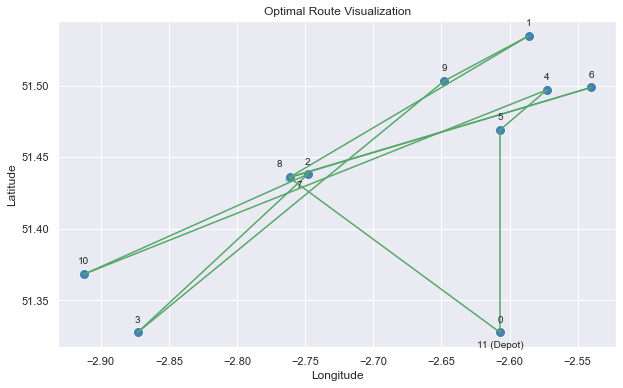

In [232]:

# Plotting the points and the optimal route using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=dist['LNG'], y=dist['LAT'], s=100, color='steelblue')

# Annotating points
# for i, (lat, lng) in enumerate(zip(dist['LAT'], dist['LNG'])):
#     plt.annotate(i, (lng, lat), textcoords="offset points", xytext=(0,10), ha='center')


for i, (lat, lng) in enumerate(zip(dist['LAT'], dist['LNG'])):
    if i == 7:
        plt.annotate(i, (lng, lat), textcoords="offset points", xytext=(10,-10), ha='center')
    elif i == 8:
        plt.annotate(i, (lng, lat), textcoords="offset points", xytext=(-10,10), ha='center')
    elif i == 11:
        plt.annotate(f'{i} (Depot)', (lng, lat), textcoords="offset points", xytext=(0,-15), ha='center')
    else:
        plt.annotate(i, (lng, lat), textcoords="offset points", xytext=(0,10), ha='center')



# Plotting the route
for start, end in route:
    plt.plot([dist['LNG'][start], dist['LNG'][end]], [dist['LAT'][start], dist['LAT'][end]], 'g-')

plt.title('Optimal Route Visualization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

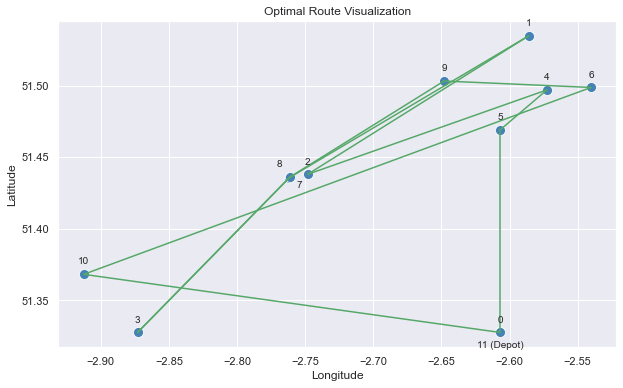

In [ ]:

# Plotting the points and the optimal route using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=dist['LNG'], y=dist['LAT'], s=100, color='steelblue')

# Annotating points
# for i, (lat, lng) in enumerate(zip(dist['LAT'], dist['LNG'])):
#     plt.annotate(i, (lng, lat), textcoords="offset points", xytext=(0,10), ha='center')


for i, (lat, lng) in enumerate(zip(dist['LAT'], dist['LNG'])):
    if i == 7:
        plt.annotate(i, (lng, lat), textcoords="offset points", xytext=(10,-10), ha='center')
    elif i == 8:
        plt.annotate(i, (lng, lat), textcoords="offset points", xytext=(-10,10), ha='center')
    elif i == 11:
        plt.annotate(f'{i} (Depot)', (lng, lat), textcoords="offset points", xytext=(0,-15), ha='center')
    else:
        plt.annotate(i, (lng, lat), textcoords="offset points", xytext=(0,10), ha='center')



# Plotting the route
for start, end in route:
    plt.plot([dist['LNG'][start], dist['LNG'][end]], [dist['LAT'][start], dist['LAT'][end]], 'g-')

plt.title('Optimal Route Visualization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()